In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import h5py
import ira_mod
import subprocess
import os

sofi = ira_mod.SOFI()

def load_molecule_hdf5(filename, idx):
    with h5py.File(filename, 'r') as f:
        coords_flat = f['coords'][idx]
        coords = coords_flat.reshape(-1, 3)
        
        atoms_str = f['atoms'][idx]
        if isinstance(atoms_str, bytes):
            atoms_str = atoms_str.decode('utf-8')
        atoms = atoms_str.split('|')
        
        return {'atoms': atoms, 'coords': coords}

def generate_scaling_functions():
    """Generate linear and sqrt scaling functions with end ranges 0.5-1.5"""
    scaling_functions = {}
    
    # Linear functions: y = 0.01 + slope * (n_atoms - 2) / 98
    # End ranges from 0.5 to 1.5, so slope = (end_range - 0.01)
    end_ranges_linear = np.linspace(0.5, 1.5, 6)
    for end_range in end_ranges_linear:
        slope = end_range - 0.01
        name = f'linear_{end_range:.2f}'
        scaling_functions[name] = lambda n_atoms, s=slope: 0.01 + s * (n_atoms - 2) / 98
    
    # Square root functions: y = 0.01 + coeff * sqrt((n_atoms - 2) / 98)
    # End ranges from 0.5 to 1.5, so coeff = (end_range - 0.01)
    end_ranges_sqrt = np.linspace(0.5, 1.5, 6)
    for end_range in end_ranges_sqrt:
        coeff = end_range - 0.01
        name = f'sqrt_{end_range:.2f}'
        scaling_functions[name] = lambda n_atoms, c=coeff: 0.01 + c * np.sqrt((n_atoms - 2) / 98)
    
    return scaling_functions

def analyze_fixed_thresholds(filename, test_indices, fixed_sym_thr_values):
    """Analyze only fixed sym_thr values"""
    results = []
    total_tests = len(test_indices)
    
    print(f"Testing {len(fixed_sym_thr_values)} fixed thresholds on {total_tests} molecules...")
    for i, idx in enumerate(test_indices):
        if (i+1) % 10000 == 0:
            print(f"  {i+1}/{total_tests}")
        
        mol = load_molecule_hdf5(filename, idx)
        atoms = mol["atoms"]
        coords = np.array(mol["coords"], dtype=float)
        nat = len(atoms)
        
        unique_atoms = list(set(atoms))
        atom_type_map = {atom: i+1 for i, atom in enumerate(sorted(unique_atoms))}
        typ = np.array([atom_type_map[atom] for atom in atoms], dtype=int)
        
        mol_results = {'idx': idx, 'n_atoms': nat}
        
        # Test fixed sym_thr values
        for sym_thr in fixed_sym_thr_values:
            try:
                with open(os.devnull, 'w') as devnull:
                    import sys
                    old_stdout, old_stderr = sys.stdout, sys.stderr
                    sys.stdout = sys.stderr = devnull
                    
                    sym = sofi.compute(nat, typ, coords, sym_thr, origin=np.mean(coords, axis=0))
                    is_collinear, _ = sofi.check_collinear(nat, coords)
                    
                    sys.stdout, sys.stderr = old_stdout, old_stderr
                
                if is_collinear:
                    pg = "Cnv" if sym.n_sym == 1 else "Dnh"
                else:
                    pg = sym.pg
                
                mol_results[sym_thr] = pg
            except:
                import sys
                sys.stdout, sys.stderr = old_stdout, old_stderr
                mol_results[sym_thr] = 'FAILED'
        
        results.append(mol_results)
    
    return pd.DataFrame(results)

def analyze_adaptive_vs_reference(filename, test_indices, scaling_functions, reference_thresholds=[0.01, 0.1]):
    """Analyze adaptive functions compared to reference fixed thresholds"""
    results = []
    total_tests = len(test_indices)
    
    print(f"Testing {len(scaling_functions)} adaptive functions + {len(reference_thresholds)} reference fixed thresholds...")
    for i, idx in enumerate(test_indices):
        mol = load_molecule_hdf5(filename, idx)
        atoms = mol["atoms"]
        coords = np.array(mol["coords"], dtype=float)
        nat = len(atoms)
        
        unique_atoms = list(set(atoms))
        atom_type_map = {atom: i+1 for i, atom in enumerate(sorted(unique_atoms))}
        typ = np.array([atom_type_map[atom] for atom in atoms], dtype=int)
        
        mol_results = {'idx': idx, 'n_atoms': nat}
        
        # Test reference fixed thresholds
        for sym_thr in reference_thresholds:
            try:
                with open(os.devnull, 'w') as devnull:
                    import sys
                    old_stdout, old_stderr = sys.stdout, sys.stderr
                    sys.stdout = sys.stderr = devnull
                    
                    sym = sofi.compute(nat, typ, coords, sym_thr, origin=np.mean(coords, axis=0))
                    is_collinear, _ = sofi.check_collinear(nat, coords)
                    
                    sys.stdout, sys.stderr = old_stdout, old_stderr
                
                if is_collinear:
                    pg = "Cnv" if sym.n_sym == 1 else "Dnh"
                else:
                    pg = sym.pg
                
                mol_results[f'fixed_{sym_thr}'] = pg
            except:
                import sys
                sys.stdout, sys.stderr = old_stdout, old_stderr
                mol_results[f'fixed_{sym_thr}'] = 'FAILED'
        
        # Test adaptive sym_thr values
        for func_name, scaling_func in scaling_functions.items():
            adaptive_sym_thr = max(0.01, min(1.5, scaling_func(nat)))
            try:
                with open(os.devnull, 'w') as devnull:
                    import sys
                    old_stdout, old_stderr = sys.stdout, sys.stderr
                    sys.stdout = sys.stderr = devnull
                    
                    sym = sofi.compute(nat, typ, coords, adaptive_sym_thr, origin=np.mean(coords, axis=0))
                    is_collinear, _ = sofi.check_collinear(nat, coords)
                    
                    sys.stdout, sys.stderr = old_stdout, old_stderr
                
                if is_collinear:
                    pg = "Cnv" if sym.n_sym == 1 else "Dnh"
                else:
                    pg = sym.pg
                
                mol_results[f'adaptive_{func_name}'] = pg
            except:
                import sys
                sys.stdout, sys.stderr = old_stdout, old_stderr
                mol_results[f'adaptive_{func_name}'] = 'FAILED'
        
        results.append(mol_results)
    
    return pd.DataFrame(results)

def plot_fixed_results(df, fixed_sym_thr_values):
    """Plot results for fixed threshold analysis"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    metrics = {
        'unique_pgs': [],
        'c1_count': [],
        'plus_minus_count': [],
        'failed_count': [],
        'disagreements_01': [],
        'disagreements_001': []
    }
    
    # Find reference columns
    ref_col_01 = None
    ref_col_001 = None
    for col in df.columns:
        if col != 'idx' and col != 'n_atoms':
            if abs(col - 0.1) < 0.02:
                ref_col_01 = col
            if abs(col - 0.01) < 0.005:
                ref_col_001 = col
    
    for thr in fixed_sym_thr_values:
        if thr in df.columns:
            col = df[thr]
            
            # Calculate metrics
            valid_pgs = col[col != 'FAILED']
            metrics['unique_pgs'].append(len(valid_pgs.unique()))
            metrics['c1_count'].append((valid_pgs == 'C1').sum())
            
            has_plus_minus = valid_pgs.str.contains(r'[+\-]', regex=True, na=False)
            metrics['plus_minus_count'].append(has_plus_minus.sum())
            metrics['failed_count'].append((col == 'FAILED').sum())
            
            # Disagreements
            if ref_col_01 is not None and thr != ref_col_01:
                disagreements = (col != df[ref_col_01]).sum()
                metrics['disagreements_01'].append(disagreements)
            else:
                metrics['disagreements_01'].append(0)
            
            if ref_col_001 is not None and thr != ref_col_001:
                disagreements = (col != df[ref_col_001]).sum()
                metrics['disagreements_001'].append(disagreements)
            else:
                metrics['disagreements_001'].append(0)
    
    # Create plots with vertical labels
    rounded_labels = [f"{thr:.2f}" for thr in fixed_sym_thr_values[:len(metrics['unique_pgs'])]]
    
    axes[0].plot(range(len(metrics['unique_pgs'])), metrics['unique_pgs'], 'o-', linewidth=2)
    axes[0].set_title('Unique Point Groups')
    axes[0].set_ylabel('Count')
    axes[0].set_xticks(range(len(rounded_labels)))
    axes[0].set_xticklabels(rounded_labels, rotation=90)
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(range(len(metrics['c1_count'])), metrics['c1_count'], 'o-', color='orange', linewidth=2)
    axes[1].set_title('C1 Point Group Count')
    axes[1].set_ylabel('Count')
    axes[1].set_xticks(range(len(rounded_labels)))
    axes[1].set_xticklabels(rounded_labels, rotation=90)
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(range(len(metrics['plus_minus_count'])), metrics['plus_minus_count'], 'o-', color='green', linewidth=2)
    axes[2].set_title('Point Groups with +/- Signs')
    axes[2].set_ylabel('Count')
    axes[2].set_xticks(range(len(rounded_labels)))
    axes[2].set_xticklabels(rounded_labels, rotation=90)
    axes[2].grid(True, alpha=0.3)
    
    axes[3].plot(range(len(metrics['failed_count'])), metrics['failed_count'], 'o-', color='red', linewidth=2)
    axes[3].set_title('Computation Failures')
    axes[3].set_ylabel('Count')
    axes[3].set_xticks(range(len(rounded_labels)))
    axes[3].set_xticklabels(rounded_labels, rotation=90)
    axes[3].grid(True, alpha=0.3)
    
    axes[4].plot(range(len(metrics['disagreements_01'])), metrics['disagreements_01'], 'o-', color='purple', linewidth=2)
    axes[4].set_title('Disagreements vs sym_thr=0.1')
    axes[4].set_ylabel('Count')
    axes[4].set_xticks(range(len(rounded_labels)))
    axes[4].set_xticklabels(rounded_labels, rotation=90)
    axes[4].grid(True, alpha=0.3)
    
    axes[5].plot(range(len(metrics['disagreements_001'])), metrics['disagreements_001'], 'o-', color='brown', linewidth=2)
    axes[5].set_title('Disagreements vs sym_thr=0.01')
    axes[5].set_ylabel('Count')
    axes[5].set_xticks(range(len(rounded_labels)))
    axes[5].set_xticklabels(rounded_labels, rotation=90)
    axes[5].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_adaptive_results(df, scaling_functions):
    """Plot results for adaptive vs reference comparison"""
    # Get all method names
    reference_methods = [col for col in df.columns if col.startswith('fixed_')]
    adaptive_methods = [col for col in df.columns if col.startswith('adaptive_')]
    all_methods = reference_methods + adaptive_methods
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    metrics = {
        'unique_pgs': [],
        'c1_count': [],
        'plus_minus_count': [],
        'failed_count': [],
        'disagreements_fixed_01': [],
        'disagreements_fixed_001': []
    }
    
    # Find reference columns
    ref_fixed_01 = next((col for col in df.columns if 'fixed_0.1' in col), None)
    ref_fixed_001 = next((col for col in df.columns if 'fixed_0.01' in col), None)
    
    method_labels = []
    for method in all_methods:
        if method in df.columns:
            col = df[method]
            if method.startswith('fixed_'):
                method_labels.append(f"F-{method.replace('fixed_', '')}")
            else:
                method_labels.append(f"A-{method.replace('adaptive_', '')}")
            
            # Calculate metrics
            valid_pgs = col[col != 'FAILED']
            metrics['unique_pgs'].append(len(valid_pgs.unique()))
            metrics['c1_count'].append((valid_pgs == 'C1').sum())
            
            has_plus_minus = valid_pgs.str.contains(r'[+\-]', regex=True, na=False)
            metrics['plus_minus_count'].append(has_plus_minus.sum())
            metrics['failed_count'].append((col == 'FAILED').sum())
            
            # Disagreements
            if ref_fixed_01 is not None and method != ref_fixed_01:
                disagreements = (col != df[ref_fixed_01]).sum()
                metrics['disagreements_fixed_01'].append(disagreements)
            else:
                metrics['disagreements_fixed_01'].append(0)
            
            if ref_fixed_001 is not None and method != ref_fixed_001:
                disagreements = (col != df[ref_fixed_001]).sum()
                metrics['disagreements_fixed_001'].append(disagreements)
            else:
                metrics['disagreements_fixed_001'].append(0)
    
    # Round method labels to 2 decimal places for numeric parts
    rounded_labels = []
    for label in method_labels:
        if '-' in label:
            prefix, suffix = label.split('-', 1)
            try:
                numeric_part = float(suffix)
                rounded_labels.append(f"{prefix}-{numeric_part:.2f}")
            except:
                rounded_labels.append(label)
        else:
            rounded_labels.append(label)
    
    # Create plots
    x = np.arange(len(rounded_labels))
    colors = ['blue' if label.startswith('F-') else 'red' for label in rounded_labels]
    
    axes[0].bar(x, metrics['unique_pgs'], color=colors, alpha=0.7)
    axes[0].set_title('Unique Point Groups')
    axes[0].set_ylabel('Count')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(rounded_labels, rotation=90)
    
    axes[1].bar(x, metrics['c1_count'], color=colors, alpha=0.7)
    axes[1].set_title('C1 Point Group Count')
    axes[1].set_ylabel('Count')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(rounded_labels, rotation=90)
    
    axes[2].bar(x, metrics['plus_minus_count'], color=colors, alpha=0.7)
    axes[2].set_title('Point Groups with +/- Signs')
    axes[2].set_ylabel('Count')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(rounded_labels, rotation=90)
    
    axes[3].bar(x, metrics['failed_count'], color=colors, alpha=0.7)
    axes[3].set_title('Computation Failures')
    axes[3].set_ylabel('Count')
    axes[3].set_xticks(x)
    axes[3].set_xticklabels(rounded_labels, rotation=90)
    
    axes[4].bar(x, metrics['disagreements_fixed_01'], color=colors, alpha=0.7)
    axes[4].set_title('Disagreements vs Fixed 0.1')
    axes[4].set_ylabel('Count')
    axes[4].set_xticks(x)
    axes[4].set_xticklabels(rounded_labels, rotation=90)
    
    axes[5].bar(x, metrics['disagreements_fixed_001'], color=colors, alpha=0.7)
    axes[5].set_title('Disagreements vs Fixed 0.01')
    axes[5].set_ylabel('Count')
    axes[5].set_xticks(x)
    axes[5].set_xticklabels(rounded_labels, rotation=90)
    
    # Add legend slightly below top
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='blue', alpha=0.7, label='Fixed sym_thr'),
                      Patch(facecolor='red', alpha=0.7, label='Adaptive sym_thr')]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.85))
    
    plt.tight_layout()
    plt.show()

def plot_scaling_functions_visual(scaling_functions):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    atom_counts = np.linspace(2, 100, 100)
    
    for func_name, scaling_func in scaling_functions.items():
        sym_thr_values = [max(0.01, min(1.5, scaling_func(n))) for n in atom_counts]
        ax.plot(atom_counts, sym_thr_values, label=func_name, linewidth=2)
    
    ax.set_xlabel('Number of Atoms')
    ax.set_ylabel('sym_thr Value')
    ax.set_title('Adaptive Scaling Functions')
    ax.legend(fontsize='small')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0.01, color='red', linestyle='--', alpha=0.5)
    ax.axhline(y=1.5, color='red', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def run_fixed_analysis(filename, n_test_molecules=50000, fixed_sym_thr_range=(0.01, 1.5), n_thresholds=30, seed=42):
    """Run analysis of fixed sym_thr values"""
    fixed_sym_thr_values = np.linspace(fixed_sym_thr_range[0], fixed_sym_thr_range[1], n_thresholds)
    
    with h5py.File(filename, 'r') as f:
        total_molecules = len(f['coords'])
    
    np.random.seed(seed)
    test_indices = np.random.choice(total_molecules, size=min(n_test_molecules, total_molecules), replace=False)
    
    print(f"=== FIXED SYM_THR ANALYSIS ===")
    print(f"Testing {len(test_indices)} molecules with {n_thresholds} fixed thresholds...")
    
    start_time = time.time()
    df = analyze_fixed_thresholds(filename, test_indices, fixed_sym_thr_values)
    print(f"Fixed analysis completed in {time.time() - start_time:.1f}s")
    
    plot_fixed_results(df, fixed_sym_thr_values)

def run_adaptive_analysis(filename, n_test_molecules=50000, seed=42):
    """Run analysis of adaptive sym_thr functions vs reference fixed values"""
    scaling_functions = generate_scaling_functions()
    
    with h5py.File(filename, 'r') as f:
        total_molecules = len(f['coords'])
    
    np.random.seed(seed)
    test_indices = np.random.choice(total_molecules, size=min(n_test_molecules, total_molecules), replace=False)
    
    print(f"=== ADAPTIVE SYM_THR ANALYSIS ===")
    print(f"Testing {len(test_indices)} molecules...")
    print(f"Adaptive functions: {len(scaling_functions)}")
    
    # Run analysis
    start_time = time.time()
    df = analyze_adaptive_vs_reference(filename, test_indices, scaling_functions)
    print(f"Adaptive analysis completed in {time.time() - start_time:.1f}s")
    
    # Plot results
    plot_adaptive_results(df, scaling_functions)
    # Show scaling functions
    plot_scaling_functions_visual(scaling_functions)

=== FIXED SYM_THR ANALYSIS ===
Testing 100000 molecules with 30 fixed thresholds...
Testing 30 fixed thresholds on 100000 molecules...
 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
 ERROR: cannot set beta. Structure not properly shifted?
 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
 small norm:   1.5000000000000000     
           5
 i=           5 j=           6
           1 -0.38667998313903817       0.12859999239444733      -0.13795999065041542     
           3  0.96642007827758780       0.11959999650716782      -0.12835999205708504     
           2 -0.83758000135421762      -0.56119997948408129       0.60213998705148697     
           2   1.2814198970794677      -0.50739999264478686       0.54444000869989395     
           3  -1.0235799908638001       0.82039998322725294      -0.88026001304388046     
 origin at: /home/turih/IterativeRotationsAssignments/src/sofi_routines.f90 line:         454
 at: /home/turih/IterativeRotationsAssignments/src/sofi_routines.f90 line:         100
     

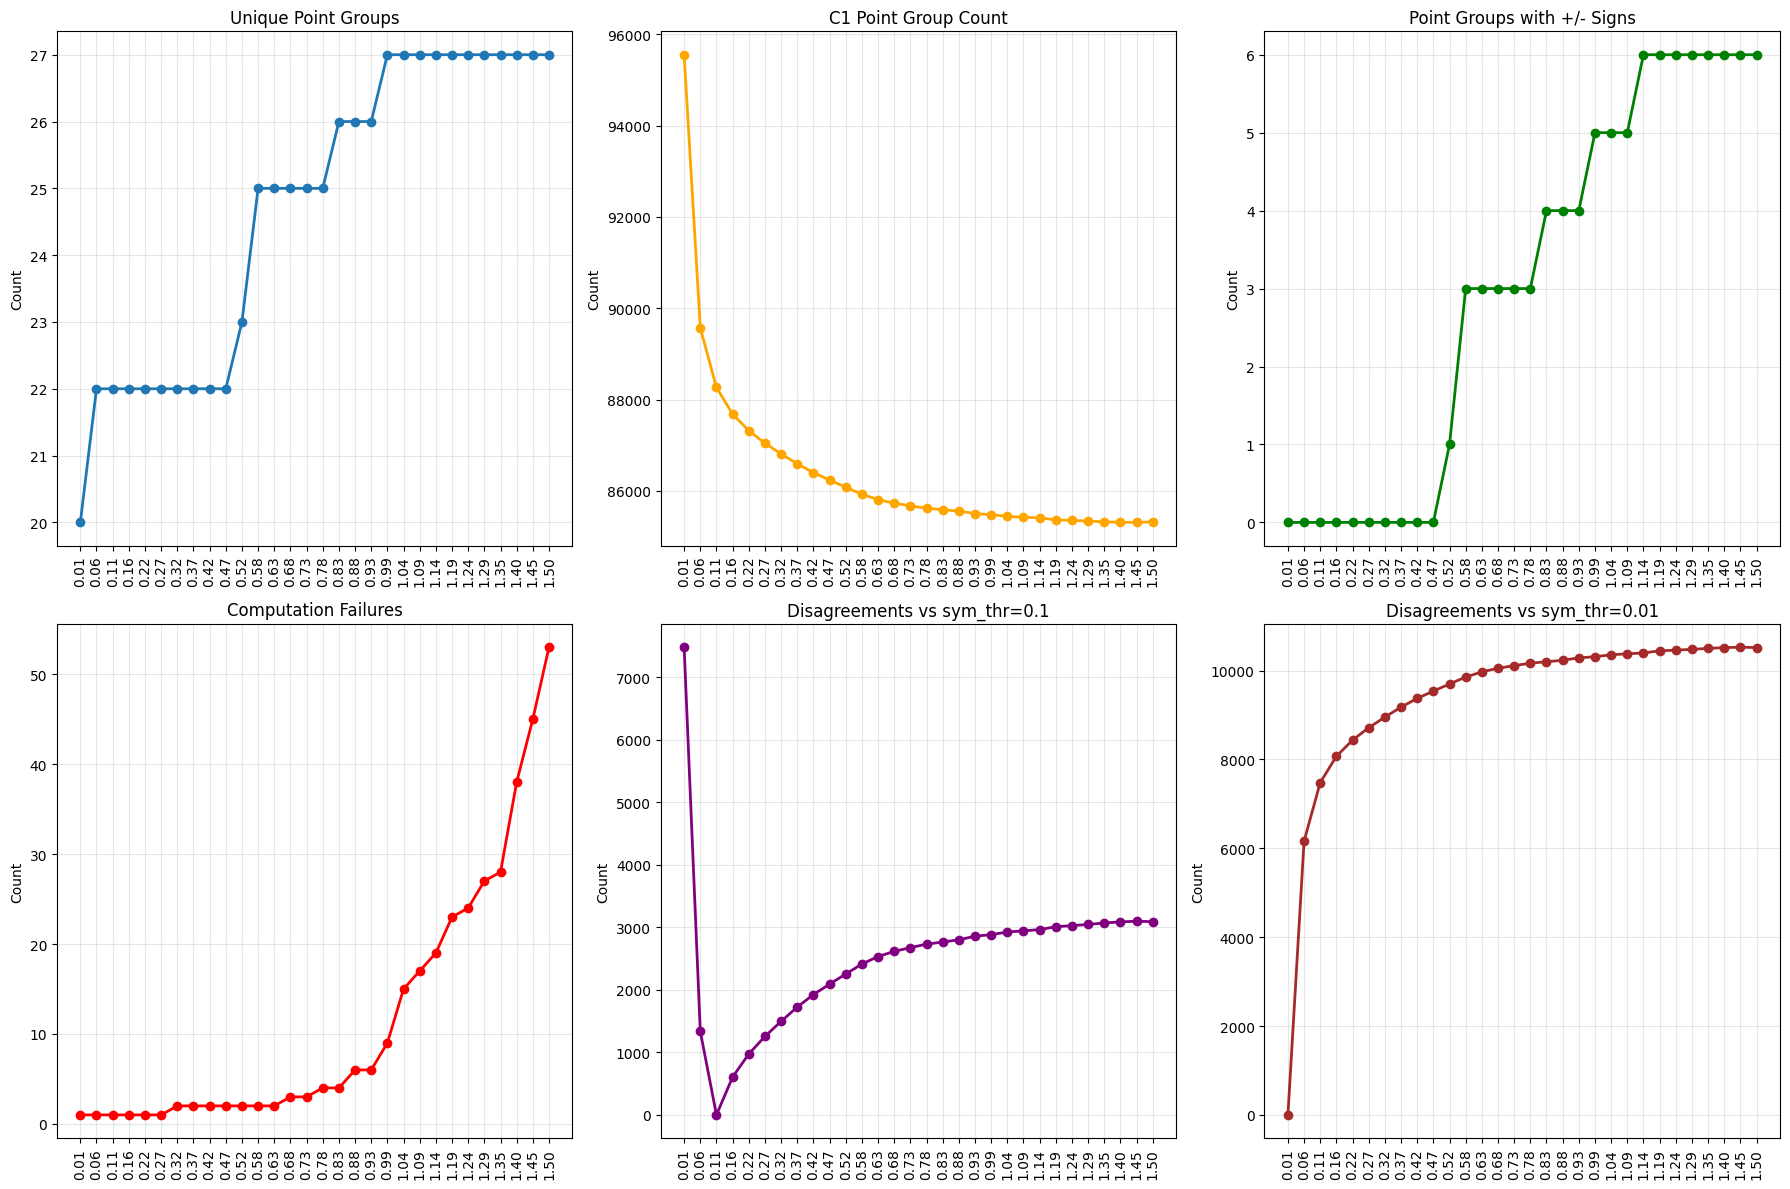

In [43]:
run_fixed_analysis("mol3d_data/mol3d_mil1.h5", n_test_molecules=100000, seed=69)

=== ADAPTIVE SYM_THR ANALYSIS ===
Testing 100000 molecules...
Adaptive functions: 12
Testing 12 adaptive functions + 2 reference fixed thresholds...
 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
 ERROR: cannot set beta. Structure not properly shifted?
 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
 small norm:  0.10000000000000001     
          17
 i=           1 j=          18
           1  0.31087695325122233        4.5235273154342892E-003   1.7529441153301961E-003
           1 -0.92322338854565267        3.8235303671921017E-003   1.7529441153301961E-003
           1   1.6529761430095231        4.9235266359413388E-003   1.4529390370144613E-003
           1  -2.2631234053303206        3.0235242755974057E-003   1.9529400502934224E-003
           1   2.8836766358684098        5.3235259564483883E-003   1.0529397165074117E-003
           1  -3.4970234755207503        2.1235239418113949E-003   2.2529451286091573E-003
           1   4.2366763230632341        3.3235293539131405E-003   8.529437815441

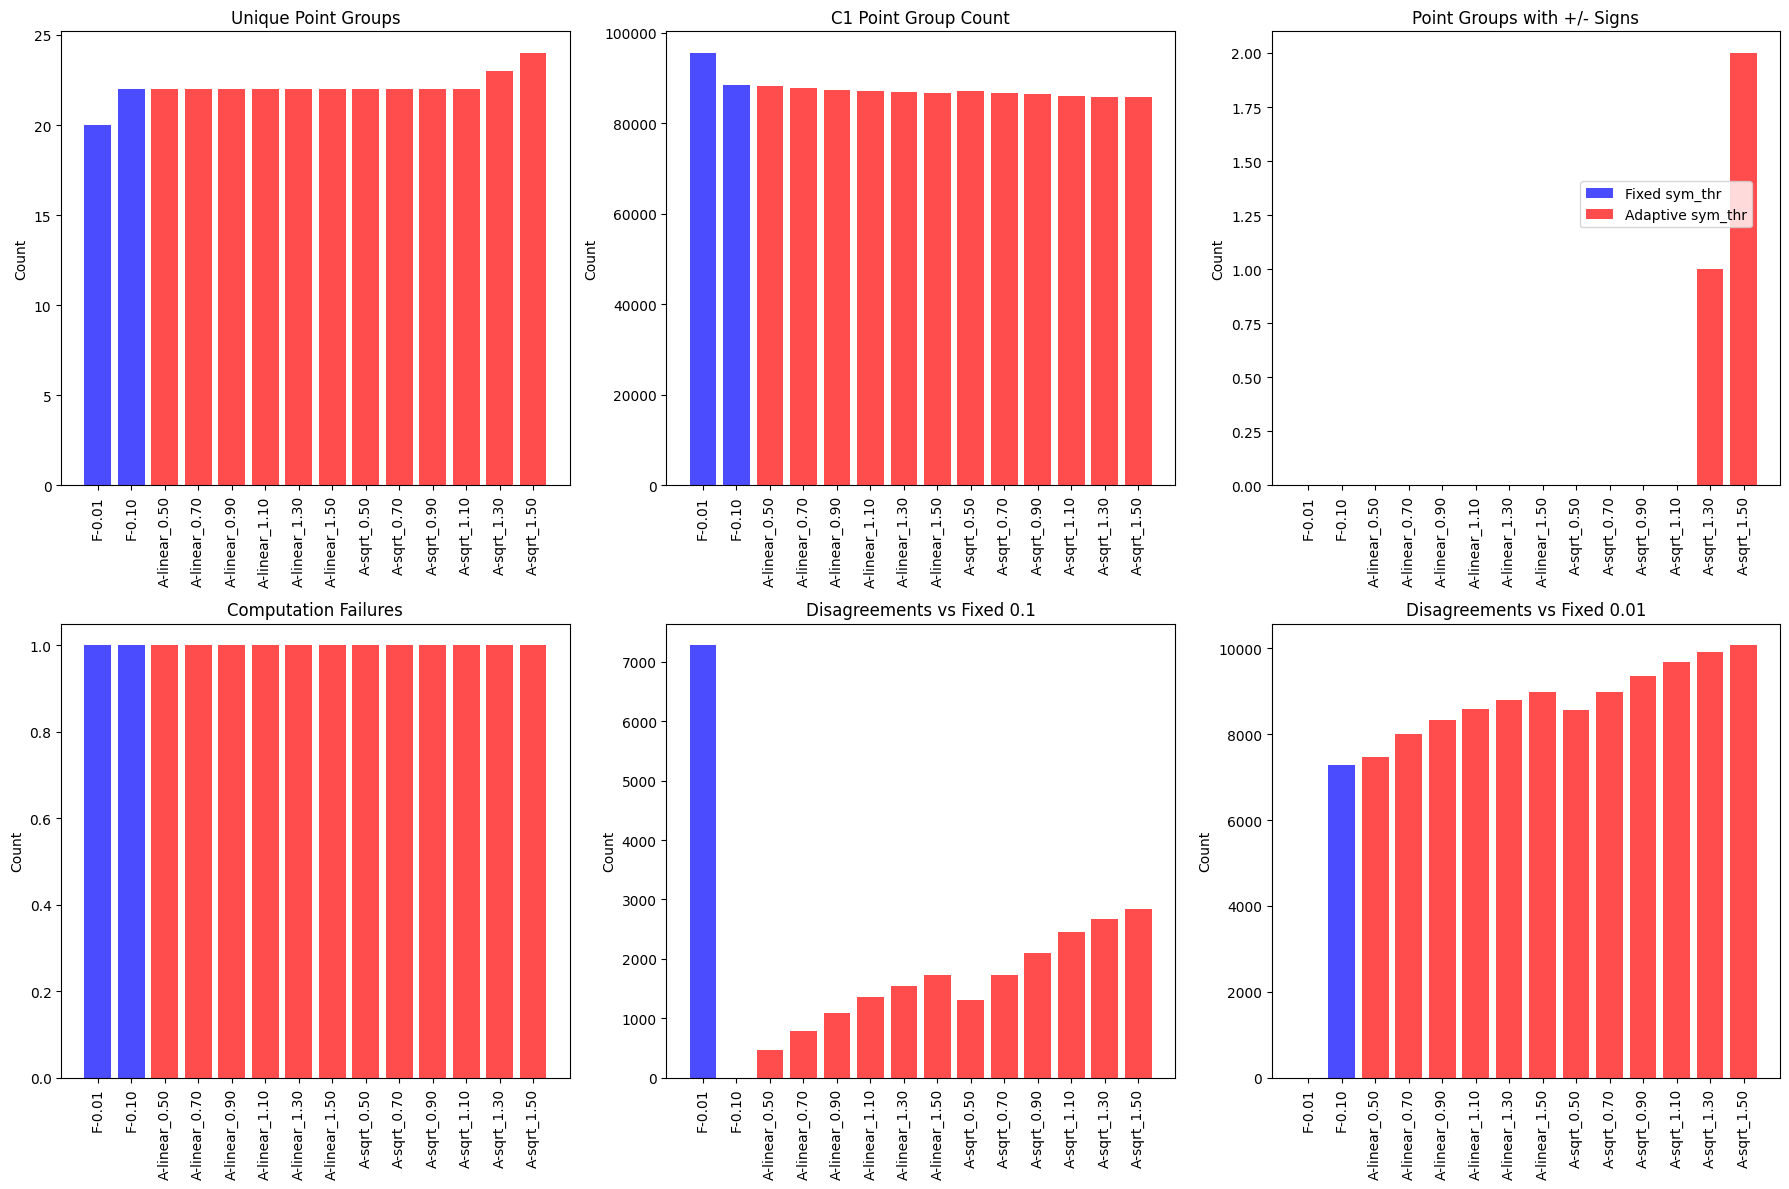

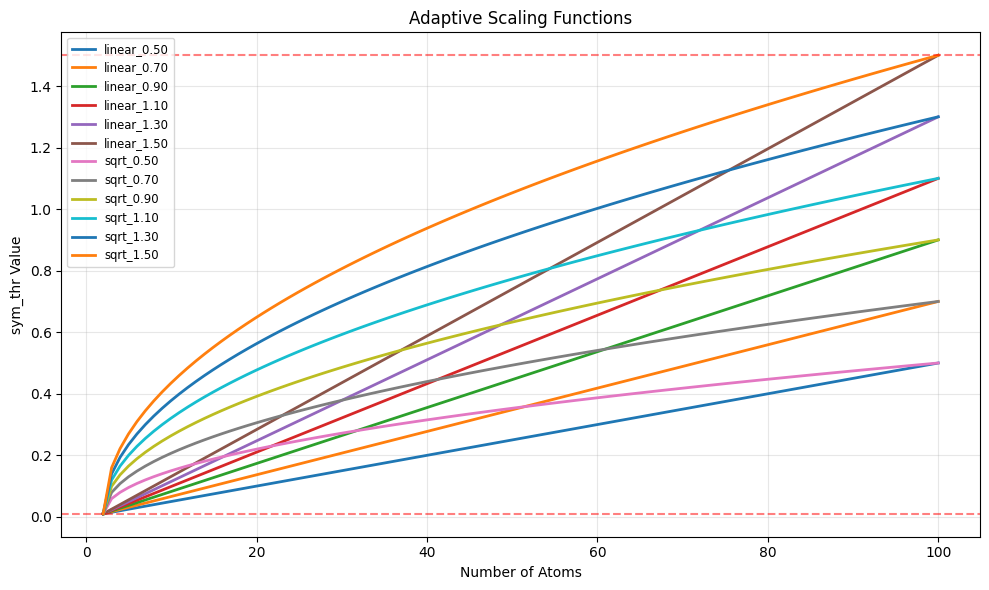

In [42]:
run_adaptive_analysis("mol3d_data/mol3d_mil1.h5", n_test_molecules=100000, seed=69)